In [91]:
install.packages('forecast')

Installing package into ‘/home/matt/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Warning message in install.packages("forecast"):
“installation of package ‘RcppArmadillo’ had non-zero exit status”
Warning message in install.packages("forecast"):
“installation of package ‘forecast’ had non-zero exit status”


In [145]:
library(dplyr)
library(data.table)
library("ggplot2")
library(forecast)
library(randomForest)
library(party)

Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich



In [300]:
mapping_classe_kwh <- fread('mapping_classe.txt')
mapping_classe_kwh<- mapping_classe_kwh %>%
    mutate(l = lag(kwh)) %>%
    mutate(l = ifelse(is.na(l), -Inf, l))

colnames(mapping_classe_kwh) = c('classe_energetica', 'kwh_ub', 'kwh_lb')

In [18]:
data <- fread('immo-data.csv')

In [278]:
data %>% glimpse()

Rows: 15,967
Columns: 39
$ affitto                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ id                     <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…
$ url                    <chr> "https://www.immobiliare.it/annunci/81379577/"…
$ url_id                 <int> 81379577, 81378845, 81371441, 81373229, 813784…
$ indirizzo              <chr> "Bologna, Colli San Mamolo, Via San Mamolo", "…
$ latitudine             <dbl> 44.47834, 44.50679, 44.38130, 44.49250, 44.437…
$ longitudine            <dbl> 11.32831, 11.37725, 11.63450, 11.30648, 11.557…
$ titolo                 <chr> "Appartamento via San Mamolo 167, Colli San Ma…
$ sottotitolo            <chr> "S.mamolo–d’azeglio prima collina in posizione…
$ descrizione_breve      <chr> "app.to mq. 210 piu’ terrazza abitabile mq. 20…
$ descrizione            <chr> "s.mamolo–d’azeglio prima collina in posizione…
$ data_inserimento       <chr> "03/07/2020", "03/07/2020", "03/07/2020", "03/…
$ tipo_immobile          <c

In [21]:
data <- data %>% mutate(classe_rimappata = case_when(classe_energetica %in% c('A+', 'A1', 'A2', 'A3', 'A4') ~ 'A+',
                                            T ~ classe_energetica))

In [35]:
mapping_classe_kwh

classe,kwh
<chr>,<dbl>
A+,14
A,29
B,58
C,87
D,116
E,145
F,175
G,Inf


In [34]:
data %>% 
    filter(kwh> 0, superficie > 0) %>%
    mutate(f_kwh = classe_rimappata %in% c('A+', 'A', 'B', 'C', 'D', 'E') & kwh>= 175) %>%
    filter(!f_kwh) %>%
    group_by(classe_rimappata) %>% 
    summarise(n = n(),
              med = median(kwh), 
              avg = mean(kwh), 
             metri_medi = mean(superficie),
             kwh_calcolati = mean(kwh/superficie, na.rm = T))


classe_rimappata,n,med,avg,metri_medi,kwh_calcolati
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
A,127,34.01,42.86449,115.0157,0.4237121
A+,1135,3.51,14.41907,130.2652,0.1499235
B,173,50.00,50.25075,124.7977,0.5726290
C,263,80.00,77.52285,125.7909,1.2103045
D,456,106.65,97.24090,121.2171,1.1257185
E,548,143.00,121.74290,121.8248,1.4645209
F,1625,175.00,405.34793,232.0566,5.2560410
G,4839,175.00,382.35633,178.3174,5.4999954


In [143]:
tipo_immobile_map <- data %>%
    group_by(tipo_immobile) %>%
    summarise(n = n()) %>%
    mutate(tot = sum(n)) %>%
    mutate(freq = (n/tot)*100) %>%
    ungroup() %>%
    mutate(new_tipo_immobile = ifelse(freq < 0.1, 'Altro', tipo_immobile)) %>%
    pull(new_tipo_immobile)
    #group_by(new_tipo_immobile) %>%
    #summarise(n = sum(n)) %>% 
    #arrange(desc(n))


In [258]:
to_model_data <- data %>% 
    filter(kwh>5, kwh < 175, superficie < 5000) %>%
    mutate(f_kwh = classe_rimappata %in% c('A+', 'A', 'B', 'C', 'D', 'E') & kwh>= 175) %>%
    filter(!f_kwh) %>% 
    select(url_id, classe_rimappata, kwh, superficie, anno_costruzione, locali, tipo_immobile) %>%
    filter(superficie>0, anno_costruzione>1700, locali != '', tipo_immobile != '' ) %>%
    mutate(tipo_immobile = ifelse(tipo_immobile %in% tipo_immobile_map, tipo_immobile, 'Altro')) %>%
    mutate(locali = as.factor(locali), 
          tipo_immobile = as.factor(tipo_immobile), 
          classe_rimappata = as.factor(classe_rimappata))

print(to_model_data %>% dim())


[1] 1421    7


In [259]:
to_model_data %>% group_by(classe_rimappata) %>% summarise(n(), median(kwh), mean(superficie))

classe_rimappata,n(),median(kwh),mean(superficie)
<fct>,<int>,<dbl>,<dbl>
A,90,35.000,120.31111
A+,208,33.705,129.23558
B,106,52.340,119.58491
C,180,80.350,127.87778
D,283,111.180,124.65724
E,325,148.610,122.82154
F,166,151.350,93.57229
G,63,136.000,122.85714


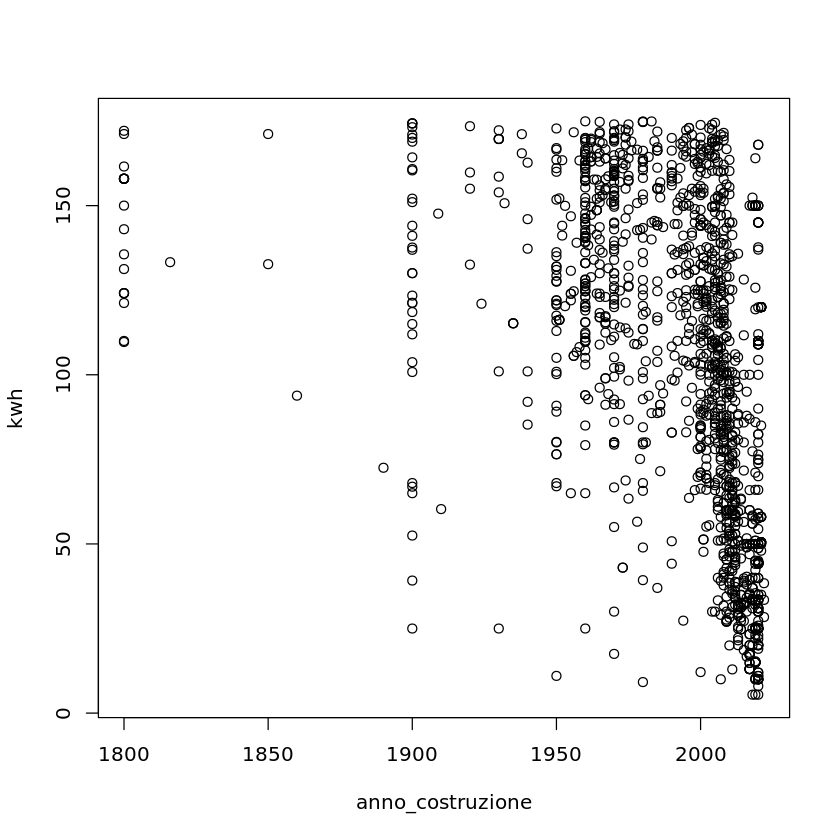

In [260]:
to_model_data %>% filter(kwh>5, kwh != 175) %>% select(anno_costruzione, kwh) %>% plot()

In [261]:
to_model_data %>% glimpse

Rows: 1,421
Columns: 7
$ url_id           <int> 81367993, 81367997, 81367981, 81342711, 81360521, 81…
$ classe_rimappata <fct> F, F, D, A+, C, E, E, E, E, E, G, F, D, D, C, G, F, …
$ kwh              <dbl> 140.50, 170.13, 79.80, 44.51, 87.90, 145.00, 145.00,…
$ superficie       <int> 240, 65, 85, 72, 60, 39, 42, 75, 40, 90, 96, 70, 130…
$ anno_costruzione <int> 1980, 2000, 2006, 2020, 2002, 2020, 2020, 1951, 2020…
$ locali           <fct> 5+, 2, 4, 3, 2, 1, 2, 2, 2, 3, 3, 3, 5, 5+, 5+, 2, 2…
$ tipo_immobile    <fct> Terratetto unifamiliare, Appartamento, Appartamento,…


In [262]:
train_perc = .7
set.seed(42)
train_ix <- sample(1:nrow(to_model_data), as.integer(nrow(to_model_data)*train_perc))
test_ix <- setdiff(1:nrow(to_model_data), train_ix)

In [263]:
train_set <- to_model_data[train_ix, ]
test_set <- to_model_data[test_ix, ]

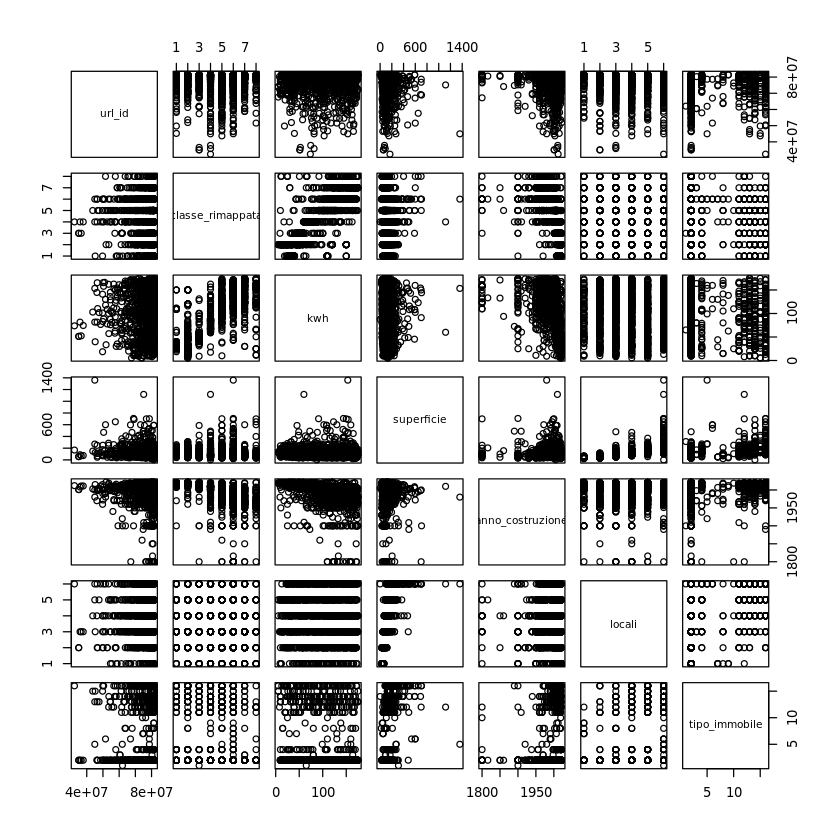

In [264]:
to_model_data %>% plot()

In [265]:
#mod <- lm(kwh ~ -1 + superficie + anno_costruzione + locali + tipo_immobile, data = train_set)
mod <- randomForest(kwh  ~ anno_costruzione + tipo_immobile + locali, data = train_set)

In [266]:
print(mod)


Call:
 randomForest(formula = kwh ~ anno_costruzione + tipo_immobile +      locali, data = train_set) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 1296.41
                    % Var explained: 43.64


In [267]:
predict <- predict(object = mod, newdata = test_set %>% select(anno_costruzione,tipo_immobile, locali))
test_set$kwh_pred <- predict
res = test_set %>% mutate(r = (kwh-kwh_pred)^2) %>% pull(r) 

print((mean(res)/length(res)) %>% sqrt)

test_set %>% select(kwh, kwh_pred) %>% plot()

In [341]:
kwh_data <- data %>% 
    filter(kwh>0) %>%
    select(url_id, classe_rimappata, kwh, superficie, anno_costruzione, locali, tipo_immobile, stato) 
kwh_data = merge(kwh_data, mapping_classe_kwh, by.x = 'classe_rimappata', by.y = 'classe_energetica')

kwh_data<- kwh_data %>% 
    filter(kwh <= kwh_ub, kwh >= kwh_lb) %>%
    filter(kwh != 175) %>%
    filter(superficie>0, anno_costruzione>1700, locali != '', tipo_immobile != '' , superficie < 1000) %>%
    mutate(tipo_immobile = ifelse(tipo_immobile %in% tipo_immobile_map, tipo_immobile, 'Altro')) %>%
    mutate(locali = as.factor(locali), 
          tipo_immobile = as.factor(tipo_immobile), 
          classe_rimappata = as.factor(classe_rimappata), 
          stato = as.factor(stato)) %>%
    select(-c(kwh_ub, kwh_lb))

kwh_data %>% glimpse

Rows: 2,589
Columns: 8
$ classe_rimappata <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A+, A+, A+…
$ url_id           <int> 77578660, 79465543, 77935064, 73942528, 81393139, 68…
$ kwh              <dbl> 27.22, 28.78, 27.20, 22.00, 27.00, 25.00, 27.00, 27.…
$ superficie       <int> 103, 65, 158, 149, 129, 98, 129, 60, 104, 80, 57, 70…
$ anno_costruzione <int> 2015, 2013, 2009, 2019, 2009, 2018, 2009, 2014, 2009…
$ locali           <fct> 4, 2, 5, 4, 5, 3, 5, 2, 4, 2, 2, 2, 2, 3, 3, 5+, 5, …
$ tipo_immobile    <fct> Appartamento, Appartamento, Appartamento, Villa unif…
$ stato            <fct> Ottimo / Ristrutturato, Ottimo / Ristrutturato, Nuov…


In [342]:
train_perc = .7
set.seed(42)
train_ix <- sample(1:nrow(kwh_data), as.integer(nrow(kwh_data)*train_perc))
test_ix <- setdiff(1:nrow(kwh_data), train_ix)

In [343]:
train_set <- kwh_data[train_ix, ]
test_set <- kwh_data[test_ix, ]

In [ ]:
#mod <- lm(kwh ~ -1 + superficie + anno_costruzione + locali + tipo_immobile, data = train_set)
mod <- randomForest(kwh  ~ anno_costruzione + tipo_immobile + stato + superficie, data = train_set)

[1] 4.068206


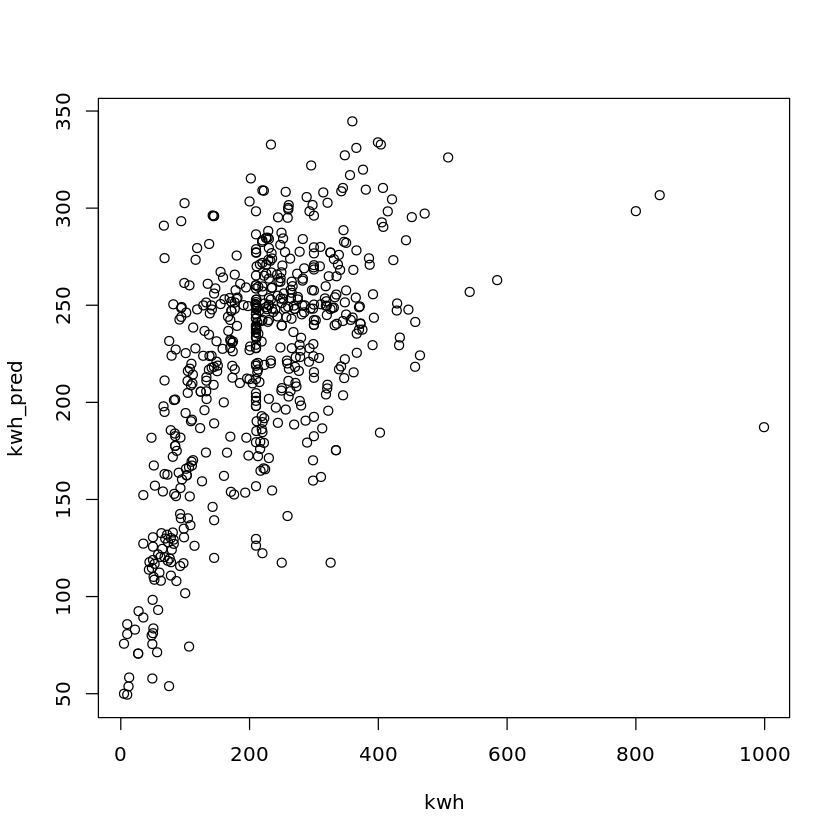

In [339]:
predict <- predict(object = mod, newdata = test_set %>% select(anno_costruzione,tipo_immobile, locali, stato, superficie))
test_set$kwh_pred <- predict
res = test_set %>% mutate(r = (kwh-kwh_pred)^2) %>% pull(r) 

print((mean(res)/length(res)) %>% sqrt)

test_set %>% select(kwh, kwh_pred) %>% plot()

In [340]:
test_set

,classe_rimappata,url_id,kwh,superficie,anno_costruzione,locali,tipo_immobile,stato,kwh_pred
,<fct>,<int>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>
4,A,73942528,22.00,149,2019,4,Villa unifamiliare,Nuovo / In costruzione,82.98602
5,A,81393139,27.00,129,2009,5,Attico,Nuovo / In costruzione,70.65056
7,A,80917039,27.00,129,2009,5,Attico,Nuovo / In costruzione,70.65056
9,A,78722291,27.63,104,2009,4,Appartamento,Nuovo / In costruzione,92.49693
15,A+,79350257,10.00,195,2020,5,Villa a schiera,Nuovo / In costruzione,49.49604
20,A+,81178343,12.00,117,2020,5,Appartamento,Nuovo / In costruzione,53.73959
23,A+,75101256,10.00,77,2020,2,Appartamento,Nuovo / In costruzione,85.79605
28,A+,76748604,5.00,138,2020,4,Appartamento,Nuovo / In costruzione,49.97546
29,A+,75101304,10.00,93,2020,3,Appartamento,Nuovo / In costruzione,80.69174
